In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary

## Treinamento a partir de uma base propria de imagens - Intel Image Classification

<td>
<img src="https://drive.google.com/uc?id=1kr__8xXIyPxIdoBaoZVKEdg0y8i8-jo7" alt="LeNet"  width="500"/> </td>





<p>
Context: This is image data of Natural Scenes around the world.
</p>

<p>
Content: This Data contains around 25k images of size 150x150 distributed under 6 categories.
  <ul>
    <li>buildings</li>
    <li>forest</li>
    <li>glacier</li>
    <li>mountain</li>
    <li>sea</li>
    <li>street</li>
  </ul>
</p>

<p>
Fonte: <a href="https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download-directory>Intel Image Classification</a>
</p>
 <a href="https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download-directory>Intel Image Classification</a>


### Usar Gdown para realizar a descarga de um arquivo desde o drive

In [3]:
# instalação da biblioteca gdown
!pip install gdown

In [4]:
# importando a biblioteca
import gdown #fazer download a partir do drive


<img src="https://drive.google.com/uc?id=1VgEEHaw-5798fIY03iWIYOIYK4-kkiNW" alt="Drawing"  width="900"/>

```
gdown --id <put-the-ID>
```

In [5]:
# Realizando a descarga usando o id do gdrive do arquivo
!gdown --id 16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft
To: /content/dataset.zip
100% 253M/253M [00:04<00:00, 50.9MB/s]


In [6]:
# biblioteca para decomprimir o arquivo zip
import zipfile
import os

In [7]:
# funçao que realiza a descarga
def unzip_dataset(filename, directory):
  """
  filename: nome do arquivo, incluir o endereço onde está localizado o arquivo
  directory: pasta onde será decomprimido o arquivo
  """
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(directory)
  zip_ref.close()

In [8]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/unzip/'
unzip_dataset(filename='/content/dataset.zip', directory=data_dir )

In [9]:
# delete files and directories
#%rm -r /tmp/*

%ls /unzip/test

buildings/  forest/  glacier/  mountain/  sea/  street/


### Preparar o dataset

In [10]:
input_size = 224
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Inializando Datasets e Dataloaders...")


# Criar conjuntos de dados de treinamento e validação
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

Inializando Datasets e Dataloaders...


In [11]:
# conjunto de treino é divido em treino (80%) e validação (20%)
train_dataset_split, val_dataset_split = torch.utils.data.random_split(image_datasets['train'], [0.8, 0.2])

In [12]:
# é adicionado no dicionario image_datasets o conjunto de validação e o conjunto de treino é atualizado
image_datasets['val'] = val_dataset_split
image_datasets['train'] = train_dataset_split

### Definição de alguns parâmetros

In [13]:
# Number of classes in the dataset
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [14]:
# Criar dataloaders de treinamento e validação
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val','test']}

# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Função que congela ou descongela as camadas da rede, por *default* são carregadas descongeladas, ou seja, permite que todos os pesos da rede sejam atualizados durante o treino.

In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#### Função que realiza o treino

In [16]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

### Função que grafica as funções de perda(custo) do treino e da validação

In [17]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

### Função que realiza a predição com a rede já treinada

In [18]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

### Função grafica a matriz de confusão como um heatmap

In [19]:
from sklearn import metrics

In [20]:
def matriz_confusao(true_labels, predicted, display_labels=[0,1,2]):
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f')
    #fig, ax = plt.subplots(figsize=(10,10))
    #disp.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

# Questão 1 - Treinar uma rede Transformer

In [21]:
model_tr = models.vit_b_32(weights='ViT_B_32_Weights.IMAGENET1K_V1')
print(model_tr)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:03<00:00, 102MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [25]:
# congela os pesos de todas as camadas da rede
set_parameter_requires_grad(model_tr, True)
# encontra o número de neurônios na última camada (camada fc)
num_ftrs = model_tr.heads.head.in_features
# troca a camada anterior por uma nova camada full connected. A saída da camada é igual ao número de classes de nossa base de imagens
model_tr.heads.head = nn.Linear(num_ftrs, num_classes)


In [23]:
print(model_tr)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Epoch 1/10 Train Loss: 0.6245 Test Loss: 0.4198763689339331 Duracao: 0:01:02.932088
Epoch 2/10 Train Loss: 0.3717 Test Loss: 0.3298670653614648 Duracao: 0:01:05.163724
Epoch 3/10 Train Loss: 0.3425 Test Loss: 0.32491889196922974 Duracao: 0:01:03.497747
Epoch 4/10 Train Loss: 0.3198 Test Loss: 0.3187068793922663 Duracao: 0:01:04.234431
Epoch 5/10 Train Loss: 0.3172 Test Loss: 0.3042018676065227 Duracao: 0:01:04.129484
Epoch 6/10 Train Loss: 0.3023 Test Loss: 0.2937164440209794 Duracao: 0:01:04.172894
Epoch 7/10 Train Loss: 0.2954 Test Loss: 0.2905562176897145 Duracao: 0:01:04.298770
Epoch 8/10 Train Loss: 0.2900 Test Loss: 0.30157882771176153 Duracao: 0:01:04.048765
Epoch 9/10 Train Loss: 0.2898 Test Loss: 0.3050013367415663 Duracao: 0:01:04.233722
Epoch 10/10 Train Loss: 0.2824 Test Loss: 0.28466954059431865 Duracao: 0:01:04.147710


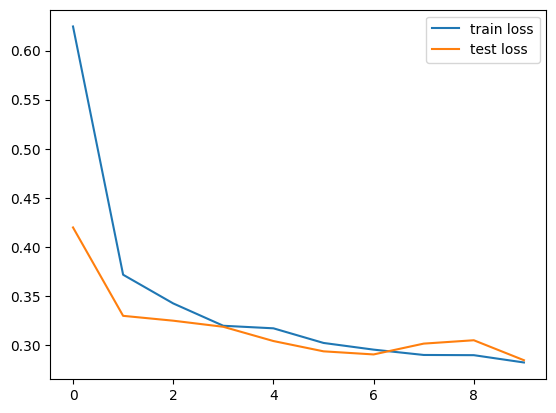

In [26]:
model_tr = model_tr.to(device)#enviar o modelo ao device (cpu/gpu)
optimizer_model_tr = optim.SGD(model_tr.parameters(), lr=0.001)# funçao de otimização
criterion_model_tr  = nn.CrossEntropyLoss()# função Loss

train_losses, test_losses = fit(model_tr , criterion_model_tr , optimizer_model_tr , dataloaders_dict['train'], dataloaders_dict['val'], epochs = 10)
plot_losses(train_losses, test_losses)

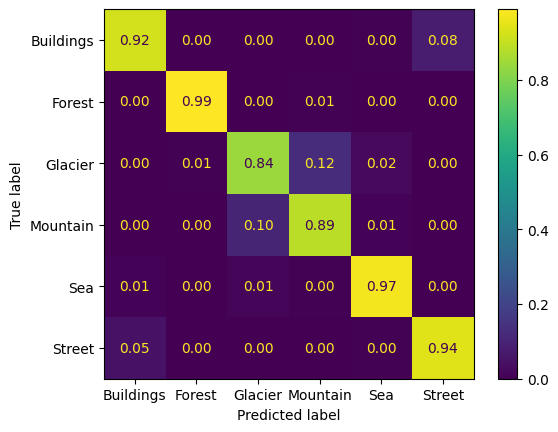

In [27]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model_tr, dataloaders_dict['test'])
matriz_confusao(true_labels, predicted, ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])